<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap10/TrialV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-cj0_cxav
Albumentation library is successfully installed!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap10/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap10
Trial.ipynb
Final.ipynb
gradcam.py
load_data.py
model.py
show_images.py
__init__.py
transforms.py
lr_finder.py
evaluate.py
train_test.py
plot.py


In [4]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import lr_finder
from template import plot

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
import albumentations as A
train_transform_list = [
                          A.Rotate((-30.0, 30.0)),
                          A.HorizontalFlip(),
                          A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [6]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


**Some Training Data**

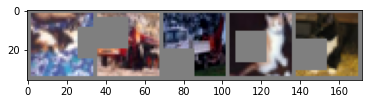

In [7]:
show_images.show_images(trainloader, classes)

**Print Model Summary**

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"

  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-2hf8z088
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


**LR Finder - Finds the best possible LR**


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 )
lrfinder = lr_finder.LRFinder(model, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=400 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


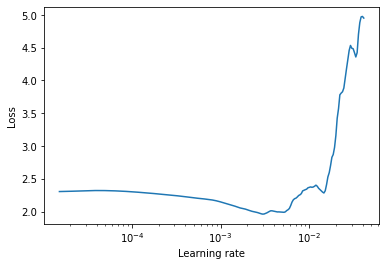

In [11]:
lrfinder.plot()

In [12]:
best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(best_lr)

0.002985382618917959


In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience = 8)

In [16]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("\n EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")

  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 1 LR: 0.002985382618917959


Loss=2.4485933780670166 Batch_id=0 Accuracy=11.72:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0182, Accuracy: 1034/10000 (10.34%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 2 LR: 0.002985382618917959


Loss=2.355464458465576 Batch_id=0 Accuracy=8.59:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 986/10000 (9.86%)


 EPOCH: 3 LR: 0.002985382618917959


Loss=2.327463150024414 Batch_id=0 Accuracy=10.94:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 883/10000 (8.83%)


 EPOCH: 4 LR: 0.002985382618917959


Loss=2.2703046798706055 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1014/10000 (10.14%)


 EPOCH: 5 LR: 0.002985382618917959


Loss=2.2813422679901123 Batch_id=0 Accuracy=12.50:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


 EPOCH: 6 LR: 0.002985382618917959


Loss=2.259277105331421 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


 EPOCH: 7 LR: 0.002985382618917959


Loss=2.2609550952911377 Batch_id=0 Accuracy=13.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


 EPOCH: 8 LR: 0.002985382618917959


Loss=2.2175962924957275 Batch_id=0 Accuracy=19.53:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 1000/10000 (10.00%)


 EPOCH: 9 LR: 0.002985382618917959


Loss=2.3017194271087646 Batch_id=0 Accuracy=13.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 1000/10000 (10.00%)


 EPOCH: 10 LR: 0.002985382618917959


Loss=2.2789194583892822 Batch_id=0 Accuracy=20.31:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 1000/10000 (10.00%)


 EPOCH: 11 LR: 0.0002985382618917959


Loss=2.2497007846832275 Batch_id=0 Accuracy=14.06:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 1000/10000 (10.00%)


 EPOCH: 12 LR: 0.0002985382618917959


Loss=2.23449444770813 Batch_id=0 Accuracy=17.19:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 1000/10000 (10.00%)


 EPOCH: 13 LR: 0.0002985382618917959


Loss=2.2354235649108887 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1000/10000 (10.00%)


 EPOCH: 14 LR: 0.0002985382618917959


Loss=2.2460904121398926 Batch_id=0 Accuracy=14.06:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10.00%)


 EPOCH: 15 LR: 0.0002985382618917959


Loss=2.252155303955078 Batch_id=0 Accuracy=14.06:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10.00%)


 EPOCH: 16 LR: 0.0002985382618917959


Loss=2.2591471672058105 Batch_id=0 Accuracy=13.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 1000/10000 (10.00%)


 EPOCH: 17 LR: 0.0002985382618917959


Loss=2.2261276245117188 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 1000/10000 (10.00%)


 EPOCH: 18 LR: 0.0002985382618917959


Loss=2.24430251121521 Batch_id=0 Accuracy=12.50:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 1000/10000 (10.00%)


 EPOCH: 19 LR: 0.0002985382618917959


Loss=2.211538553237915 Batch_id=0 Accuracy=15.62:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 1000/10000 (10.00%)


 EPOCH: 20 LR: 2.985382618917959e-05


Loss=2.14475679397583 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1000/10000 (10.00%)


 EPOCH: 21 LR: 2.985382618917959e-05


Loss=2.1744604110717773 Batch_id=0 Accuracy=21.09:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1000/10000 (10.00%)


 EPOCH: 22 LR: 2.985382618917959e-05


Loss=2.273221731185913 Batch_id=0 Accuracy=19.53:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 1000/10000 (10.00%)


 EPOCH: 23 LR: 2.985382618917959e-05


Loss=2.143303632736206 Batch_id=0 Accuracy=17.19:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 1000/10000 (10.00%)


 EPOCH: 24 LR: 2.985382618917959e-05


Loss=2.201842784881592 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 1000/10000 (10.00%)


 EPOCH: 25 LR: 2.985382618917959e-05


Loss=2.2677180767059326 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 1000/10000 (10.00%)


 EPOCH: 26 LR: 2.985382618917959e-05


Loss=2.215153217315674 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 1000/10000 (10.00%)


 EPOCH: 27 LR: 2.985382618917959e-05


Loss=2.298574447631836 Batch_id=0 Accuracy=17.19:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 1000/10000 (10.00%)


 EPOCH: 28 LR: 2.985382618917959e-05


Loss=2.2572057247161865 Batch_id=0 Accuracy=19.53:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 1000/10000 (10.00%)


 EPOCH: 29 LR: 2.9853826189179593e-06


Loss=2.235963821411133 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 1000/10000 (10.00%)


 EPOCH: 30 LR: 2.9853826189179593e-06


Loss=2.2587268352508545 Batch_id=0 Accuracy=11.72:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 1000/10000 (10.00%)


 EPOCH: 31 LR: 2.9853826189179593e-06


Loss=2.229612350463867 Batch_id=0 Accuracy=21.09:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1000/10000 (10.00%)


 EPOCH: 32 LR: 2.9853826189179593e-06


Loss=2.2245771884918213 Batch_id=0 Accuracy=14.06:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1002/10000 (10.02%)


 EPOCH: 33 LR: 2.9853826189179593e-06


Loss=2.2196435928344727 Batch_id=0 Accuracy=14.84:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 1002/10000 (10.02%)


 EPOCH: 34 LR: 2.9853826189179593e-06


Loss=2.2493205070495605 Batch_id=0 Accuracy=11.72:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 1005/10000 (10.05%)


 EPOCH: 35 LR: 2.9853826189179593e-06


Loss=2.163254976272583 Batch_id=0 Accuracy=13.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 1005/10000 (10.05%)


 EPOCH: 36 LR: 2.9853826189179593e-06


Loss=2.1583540439605713 Batch_id=0 Accuracy=25.78:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 1013/10000 (10.13%)


 EPOCH: 37 LR: 2.9853826189179593e-06


Loss=2.2159321308135986 Batch_id=0 Accuracy=15.62:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1017/10000 (10.17%)


 EPOCH: 38 LR: 2.9853826189179596e-07


Loss=2.221832513809204 Batch_id=0 Accuracy=20.31:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0184, Accuracy: 1036/10000 (10.36%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 39 LR: 2.9853826189179596e-07


Loss=2.2166600227355957 Batch_id=0 Accuracy=20.31:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0183, Accuracy: 1053/10000 (10.53%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 40 LR: 2.9853826189179596e-07


Loss=2.175203561782837 Batch_id=0 Accuracy=19.53:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0182, Accuracy: 1080/10000 (10.80%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 41 LR: 2.9853826189179596e-07


Loss=2.194671630859375 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0181, Accuracy: 1112/10000 (11.12%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 42 LR: 2.9853826189179596e-07


Loss=2.245262384414673 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0180, Accuracy: 1166/10000 (11.66%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 43 LR: 2.9853826189179596e-07


Loss=2.2388291358947754 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0179, Accuracy: 1228/10000 (12.28%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 44 LR: 2.9853826189179596e-07


Loss=2.235710620880127 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0178, Accuracy: 1298/10000 (12.98%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 45 LR: 2.9853826189179596e-07


Loss=2.2330968379974365 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0178, Accuracy: 1358/10000 (13.58%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 46 LR: 2.9853826189179596e-07


Loss=2.2365524768829346 Batch_id=0 Accuracy=16.41:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0177, Accuracy: 1428/10000 (14.28%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 47 LR: 2.9853826189179596e-07


Loss=2.2671945095062256 Batch_id=0 Accuracy=10.94:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0176, Accuracy: 1481/10000 (14.81%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 48 LR: 2.9853826189179596e-07


Loss=2.2376205921173096 Batch_id=0 Accuracy=18.75:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0176, Accuracy: 1533/10000 (15.33%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 49 LR: 2.9853826189179596e-07


Loss=2.3045170307159424 Batch_id=0 Accuracy=11.72:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0175, Accuracy: 1602/10000 (16.02%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 50 LR: 2.9853826189179596e-07


Loss=2.2259726524353027 Batch_id=0 Accuracy=17.19:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0175, Accuracy: 1649/10000 (16.49%)

accuracy increased, Saving model....


**Load the Best Accuracy Model**


In [17]:
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [18]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 16 %


In [19]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane :  0 %
Accuracy of   car : 11 %
Accuracy of  bird :  0 %
Accuracy of   cat :  5 %
Accuracy of  deer : 91 %
Accuracy of   dog :  2 %
Accuracy of  frog : 11 %
Accuracy of horse :  0 %
Accuracy of  ship : 17 %
Accuracy of truck : 16 %


**Plot Loss Change in test**


Text(0.5, 1.0, 'Test Accuracy')

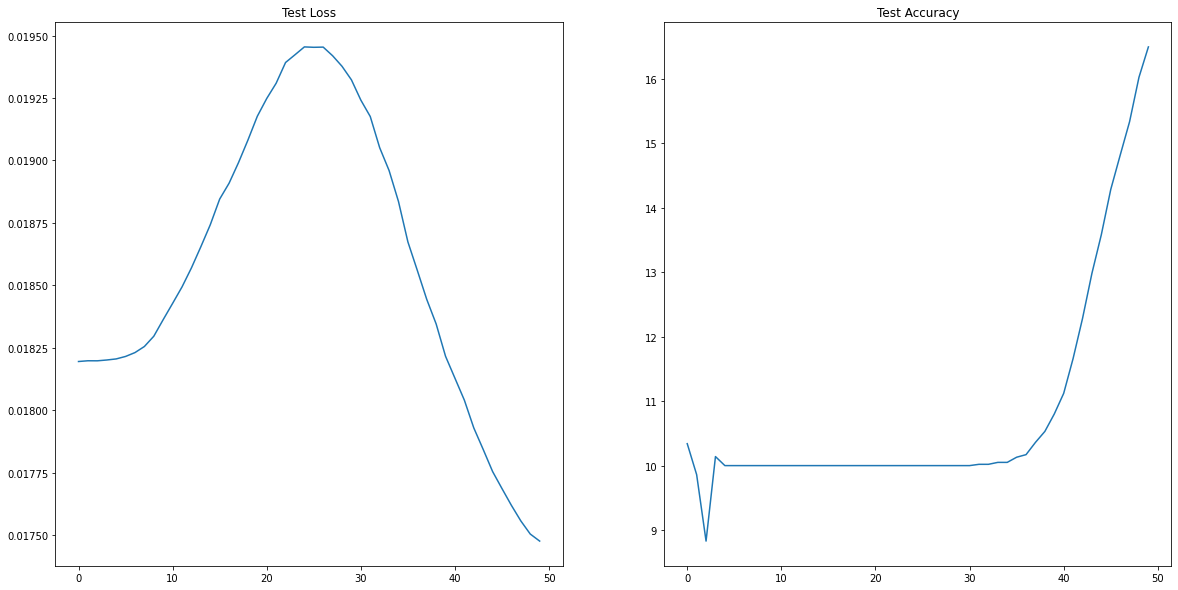

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

**Plot Loss Change in train**


Text(0.5, 1.0, 'Train Accuracy')

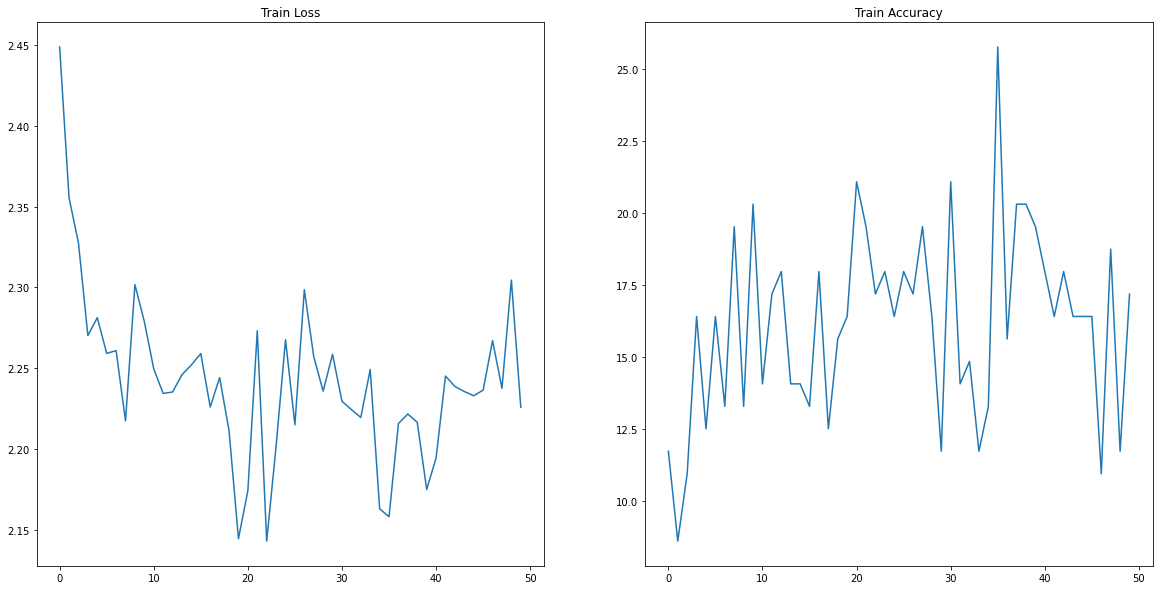

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(train_loss)
axs[0].set_title("Train Loss")

axs[1].plot(train_acc)
axs[1].set_title("Train Accuracy")

**Plot changes in Training and Test accuracy**

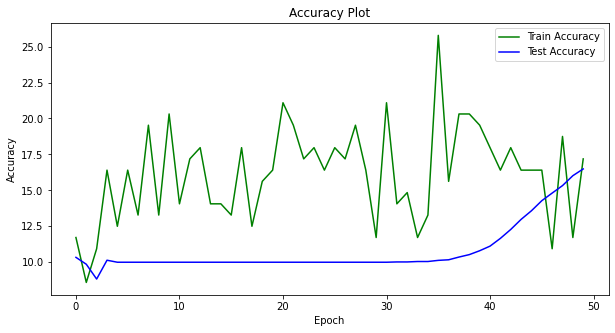

In [22]:
plot.plot_train_test_accuracy(train_acc,test_acc)

In [0]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

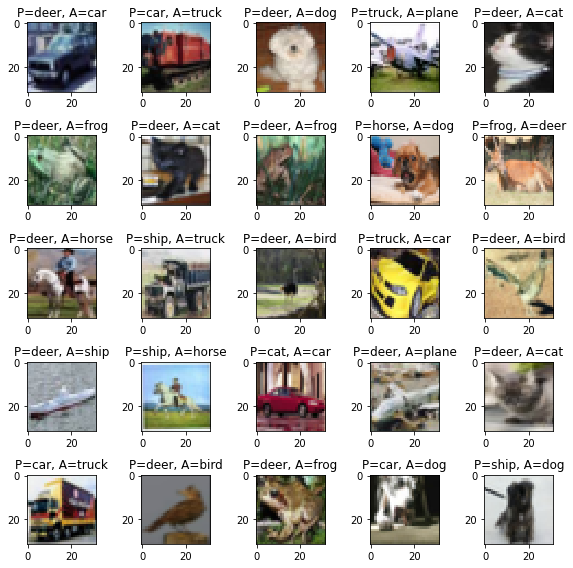

In [24]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

**GradCam View of misclassified images(for all 4 layers)**


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


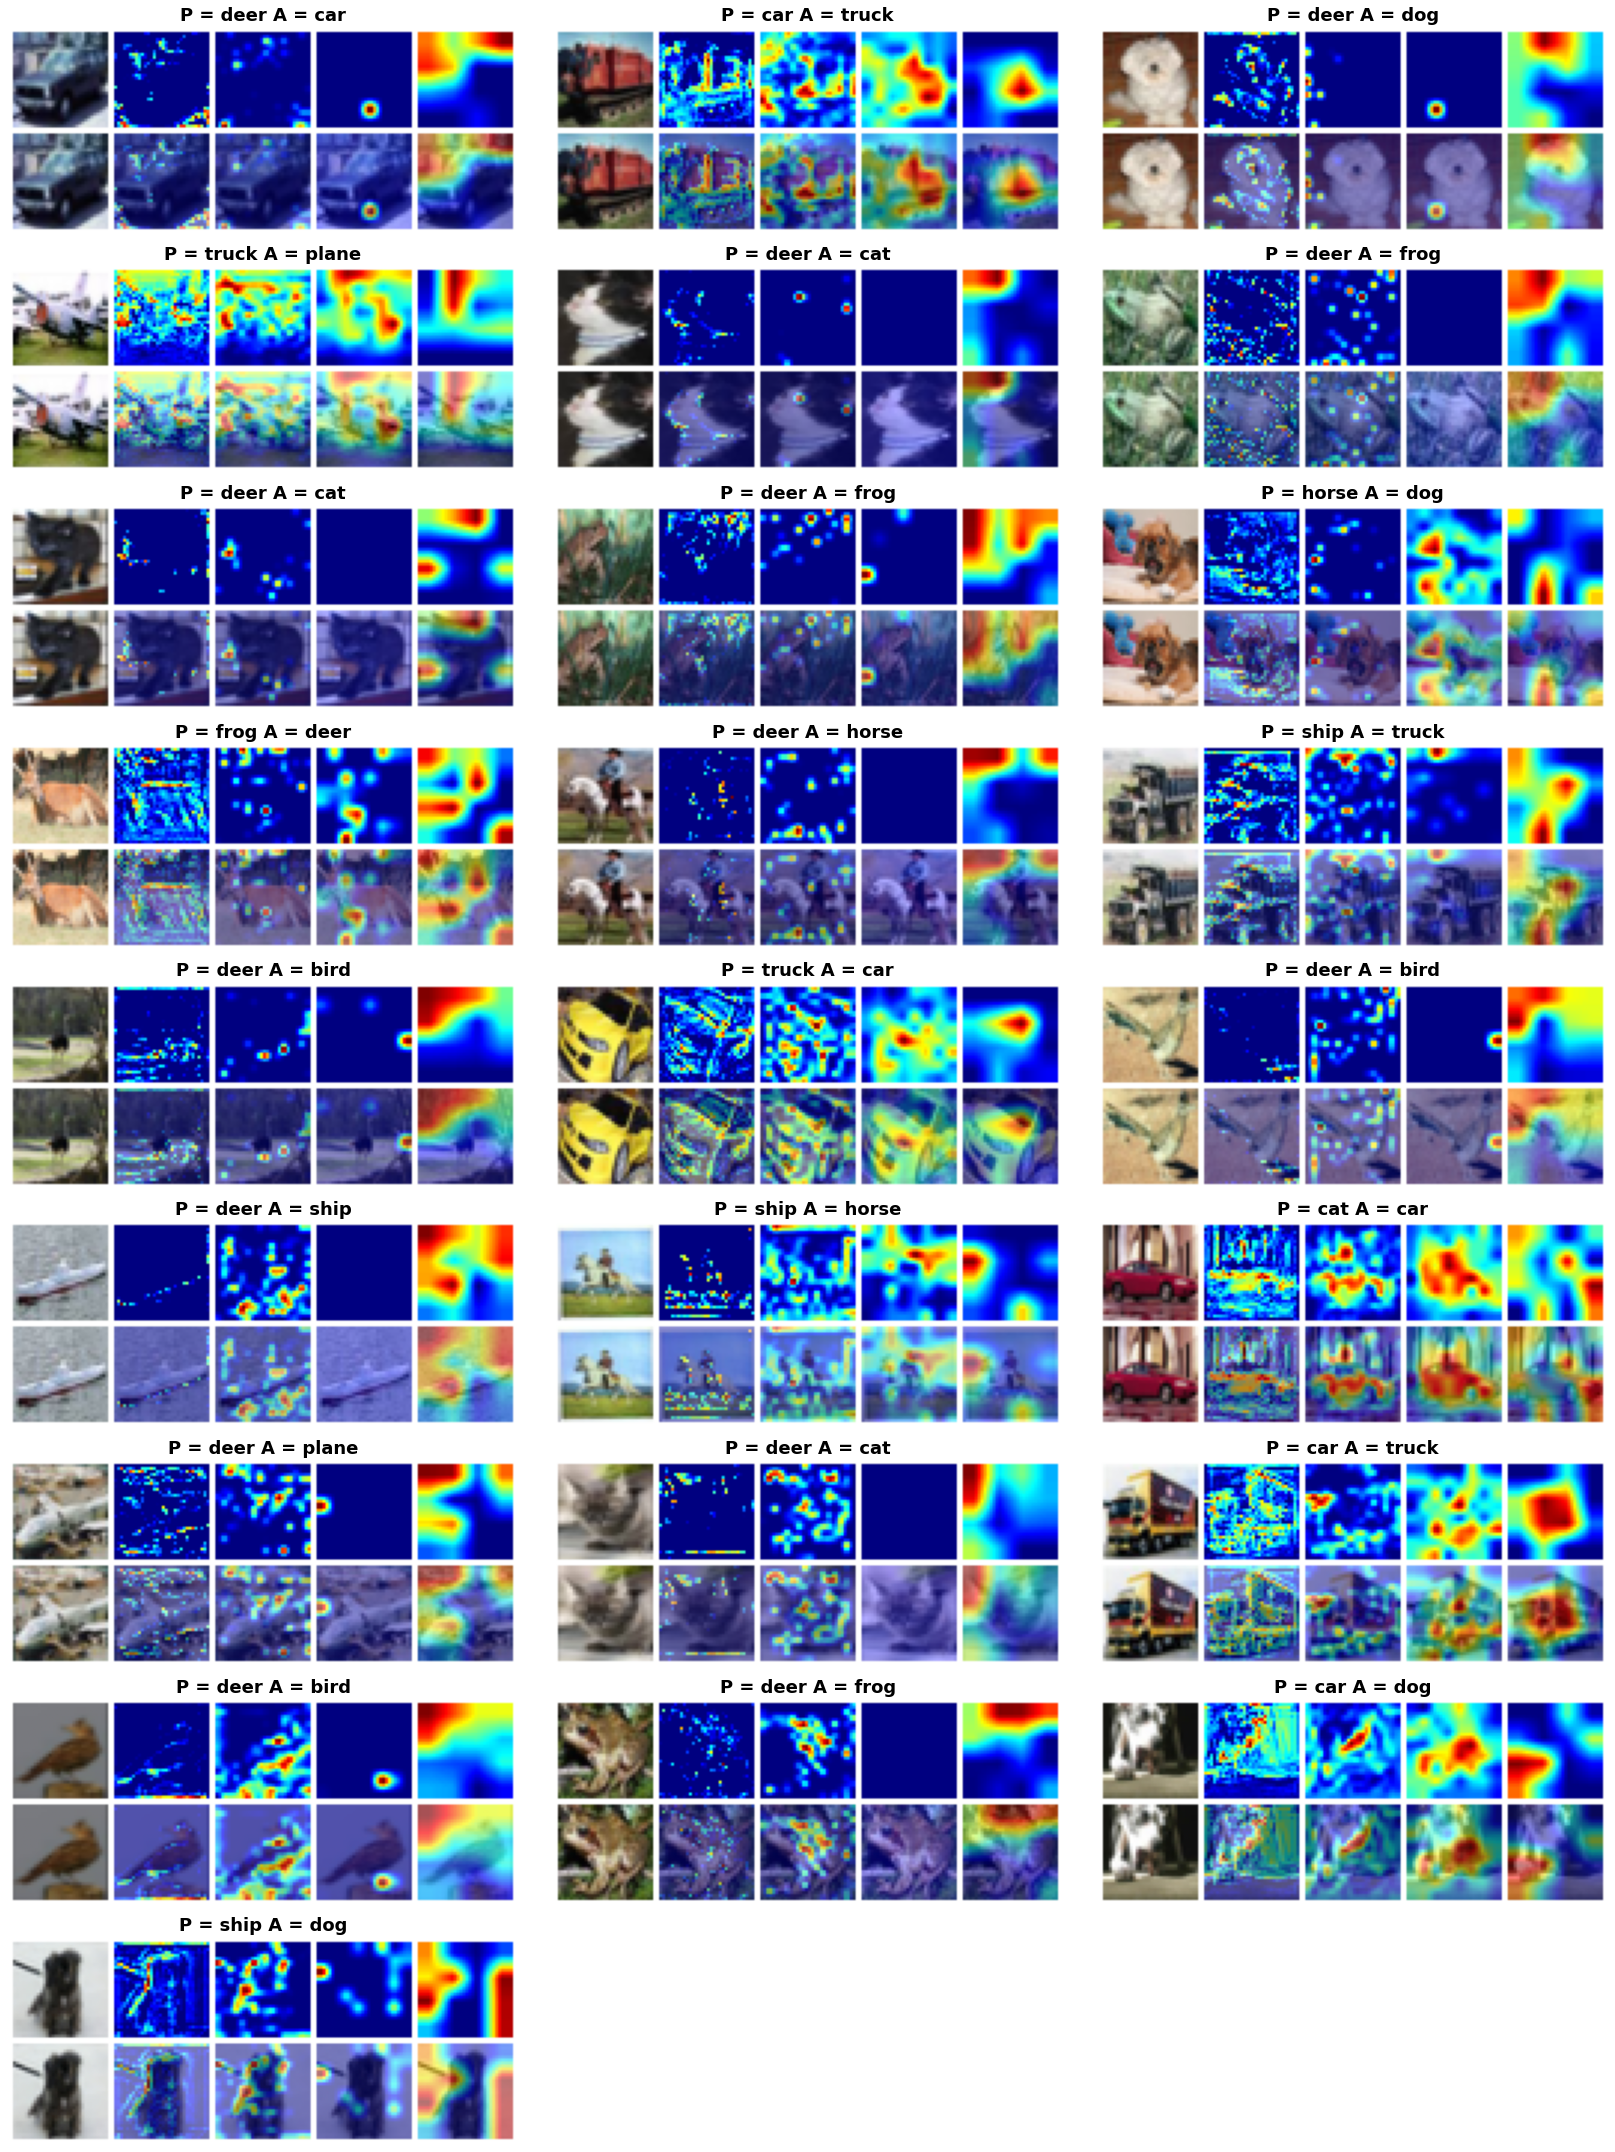

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = model.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [model.layer1,model.layer2,model.layer3,model.layer4]
  for j in layers:
    g = gradcam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = gradcam.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)